In [1]:
# Third party imports
import sys,os
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from geopy.distance import distance

# Local imports
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from wgpack.dservice import readDS_ADCP_C4T
from wgpack.nav import get_bearing


/Users/a1amador/src/wgpack


In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# Inputs
# ----------------------------------------------------------------------------------------------------------------------
# vnam: vehicle name
# tw: time window to display specified in days (ends at ten). If None, tst defaults to specified start date
# ten: end time
# msk_flg: mask contaminated bins due to Wave Glider sub acoustic interference (boolean) 

# Get data through dataservice
vnam = 'sv3-1103'
tw = None
print('vehicle:',vnam)
msk_sub_flg = True

# ----------------------------------------------------------------------------------------------------------------------
# Set start date according to the time window to be considered
# ----------------------------------------------------------------------------------------------------------------------
now = datetime.datetime.utcnow()
if tw is not None:
    # use specified time window
    start_date = now - pd.Timedelta(days=float(tw))
    end_date = now
else:
    # use last 7 days
    start_date = pd.to_datetime('04-08-2023 02:00:00')
    end_date = pd.to_datetime('04-11-2023 14:00:00')

print('time window:', start_date, ' to ',end_date)

# ----------------------------------------------------------------------------------------------------------------------
# Retrieve data
# ----------------------------------------------------------------------------------------------------------------------
C4T_dic = readDS_ADCP_C4T(vnam, start_date, end_date=end_date)

if msk_sub_flg:
    # mask contaminated bins due to Wave Glider sub acoustic interference (boolean) 
    print("masking contaminated bins due to glider sub acoustic interference")     
    sub_depth1 = 8  # m (primary interference)
    sub_depth2 = 16 # m (secondary interference)
    sub_depth3 = 24 # m (tertiary interference)
    jjsub1 = np.abs(C4T_dic['ranges']-sub_depth1).argmin()
    jjsub2 = np.abs(C4T_dic['ranges']-sub_depth2).argmin()
    jjsub3 = np.abs(C4T_dic['ranges']-sub_depth3).argmin()

    # Evel
    C4T_dic['Evel'][jjsub1,:]=np.nan
    C4T_dic['Evel'][jjsub2,:]=np.nan

    # Nvel
    C4T_dic['Nvel'][jjsub1,:]=np.nan
    C4T_dic['Nvel'][jjsub2,:]=np.nan

    
# Calculate cog and sog from WG MWG coordinates
lon = C4T_dic['longitude']
lat = C4T_dic['latitude']
tt_WG = C4T_dic['time']
sog_lonlat_adcp,cog_lonlat_adcp=[],[]
for ii,t in enumerate(tt_WG[:-1]):
    p1 = (lat[ii],lon[ii])
    p2 = (lat[ii+1],lon[ii+1])
    delt = (tt_WG[ii+1]-t)/np.timedelta64(1, 's')      
    sogtmp = distance(p1,p2).m/delt if delt>0 else np.nan 
    sog_lonlat_adcp.append(sogtmp)
    cog_lonlat_adcp.append(get_bearing(p1,p2))


vehicle: sv3-1103
time window: 2023-04-08 02:00:00  to  2023-04-11 14:00:00
masking contaminated bins due to glider sub acoustic interference


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_55615/1811235752.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_55615/1811235752.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)


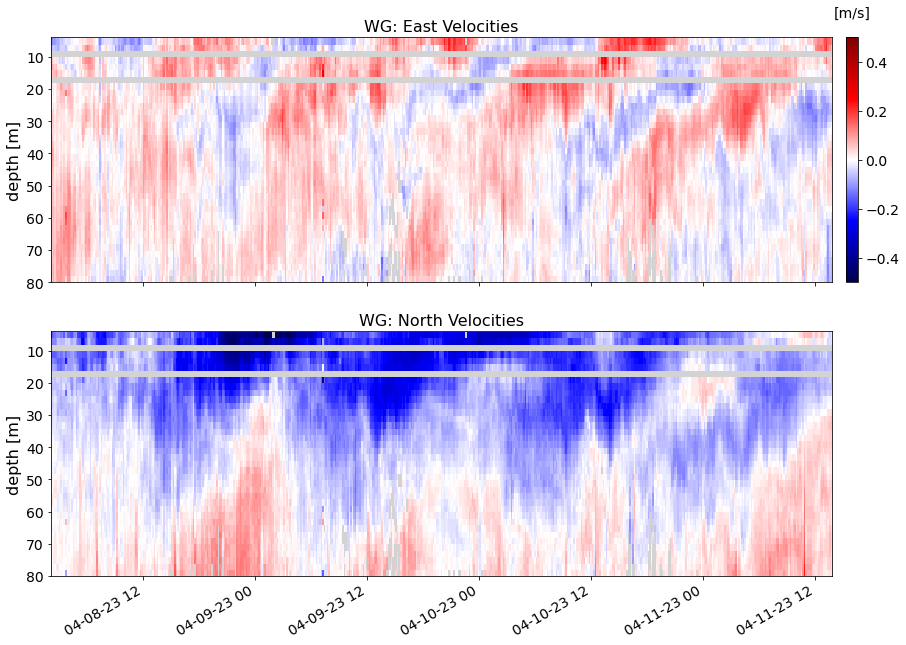

In [3]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot results
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

tt_WG = C4T_dic['time']
ranges_WG = C4T_dic['ranges']
# motion-corrected velocities
U_WG = C4T_dic['Evel']
V_WG = C4T_dic['Nvel']

# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1]
nrows = 2
ncols = 1
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(14, 11))

# WG: East Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
c = ax[0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0].set_ylim(yL)
ax[0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0].set_title('WG: East Velocities',fontsize=fntsz)
ax[0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
ax[1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1].set_ylim(yL)
ax[1].set_ylabel(ylab_str,fontsize=fntsz)
ax[1].set_title('WG: North Velocities',fontsize=fntsz)
ax[1].invert_yaxis()


# rotate and align the tick labels so they look better
ax[0].tick_params(labelsize=labsz)
ax[1].tick_params(labelsize=labsz)

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()


# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]\n",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)


# save figure
# fig.savefig('/Users/a1amador/Downloads/'+vnam+'_adcp_C4T.jpg')


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_55615/243848187.py:45: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_55615/243848187.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)


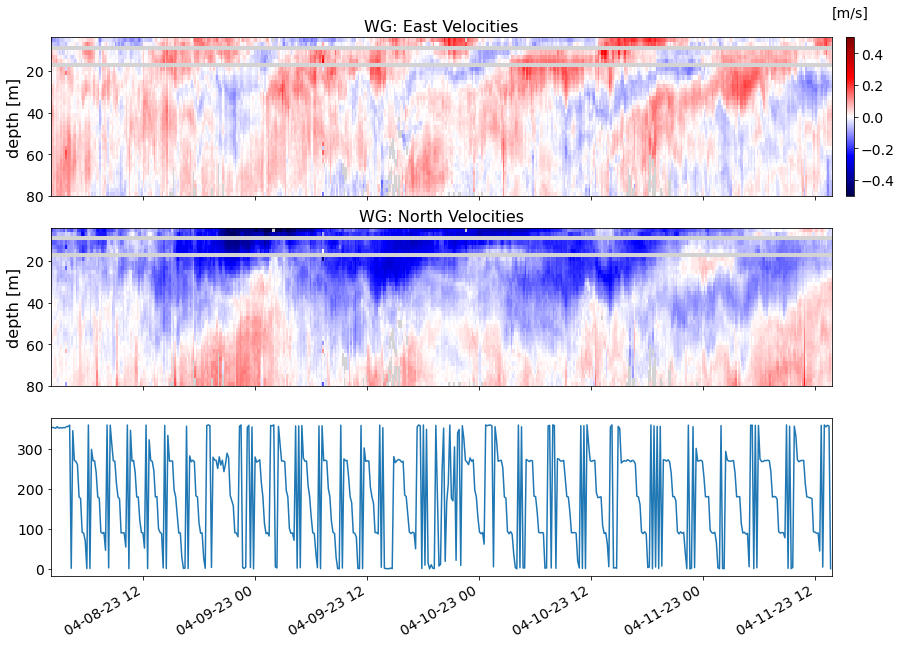

In [4]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot results
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

tt_WG = C4T_dic['time']
ranges_WG = C4T_dic['ranges']
# motion-corrected velocities
U_WG = C4T_dic['Evel']
V_WG = C4T_dic['Nvel']


head_flg = True
# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

ncols = 1
if head_flg:
    nrows = 3        
else:
    # Do not show vehicle heading
    nrows = 2
heights = np.ones(nrows)
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(14, 11))

# WG: East Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
c = ax[0].pcolormesh(x,y,U_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0].set_ylim(yL)
ax[0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0].set_title('WG: East Velocities',fontsize=fntsz)
ax[0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(tt_WG,ranges_WG)
ax[1].pcolormesh(x,y,V_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1].set_ylim(yL)
ax[1].set_ylabel(ylab_str,fontsize=fntsz)
ax[1].set_title('WG: North Velocities',fontsize=fntsz)
ax[1].invert_yaxis()

# show heading
if head_flg:
    ax[2].plot(tt_WG[:-1],cog_lonlat_adcp)
    ax[2].tick_params(labelsize=labsz)

# rotate and align the tick labels so they look better
ax[0].tick_params(labelsize=labsz)
ax[1].tick_params(labelsize=labsz)

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[-1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()


# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]\n",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

# save figure
# fig.savefig('/Downloads/'+vnam+'_adcp_C4T.jpg')


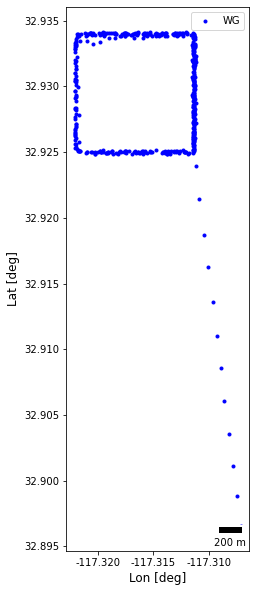

In [5]:
# Plot map
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import distance


_y = np.nanmedian(C4T_dic['latitude'])

# Define levels in z-axis where we want lines to appear
levels = np.linspace(-275,0,12)


# Initialize plot objects
rcParams['figure.figsize'] = 5, 10 # sets plot size
# set negative contours to be solid instead of dashed:
plt.rcParams['contour.negative_linestyle'] = 'solid'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot(C4T_dic['longitude'],C4T_dic['latitude'],'.b',label='WG')
# ax.plot(simplified[:,0],simplified[:,-1],'or',label='turning')

# set legend
ax.legend()
# set aspect ratio
ax.set_aspect(aspect=1/np.cos(_y*np.pi/180))
# set axis labels
ax.set_xlabel('Lon [deg]', fontsize=12)
ax.set_ylabel('Lat [deg]', fontsize=12)
# # set axis limits
# ax.set_ylim(yL)
# ax.set_xlim(xL);

# Specify format of floats for tick labels
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# scalebar
dx = distance((_y,ax.get_xlim()[0]),(_y,ax.get_xlim()[0]+1)).m
scalebar = ScaleBar(dx=dx,units='m',location='lower right') 
plt.gca().add_artist(scalebar)

